A gente bastante coisa que dá para fazer para melhor as metricas e scorers do modelo. Vimos como analisar a colunas, analisar as assimetria para escolher o melhor preprocessing para ela, agora é hora de ajuntar tudo isso.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from src.graficos import plot_comparar_metricas_modelos
from src.modelos import organiza_resultados, treinar_e_validar_modelo_regressao
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, PowerTransformer, QuantileTransformer
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor

import seaborn as sns

RANDOM_STATE = 42

In [2]:
df = pd.read_parquet("../dados/diabete_categorizado.parquet")

df

,idade,sexo,imc,pressao_media,colesterol_total,ldl,hdl,triglicerides,glicose,target,colesterol_hdl_cat
0,59,2,32.1,101.00,157,93.2,38.0,4.8598,87,151,4-5
1,48,1,21.6,87.00,183,103.2,70.0,3.8918,69,75,2-3
2,72,2,30.5,93.00,156,93.6,41.0,4.6728,85,141,4-5
3,24,1,25.3,84.00,198,131.4,40.0,4.8903,89,206,4-5
4,50,1,23.0,101.00,192,125.4,52.0,4.2905,80,135,4-5
...,...,...,...,...,...,...,...,...,...,...,...
437,60,2,28.2,112.00,185,113.8,42.0,4.9836,93,178,4-5
438,47,2,24.9,75.00,225,166.0,42.0,4.4427,102,104,4-5
439,60,2,24.9,99.67,162,106.6,43.0,4.1271,95,132,4-5
440,36,1,30.0,95.00,201,125.2,42.0,5.1299,85,220,4-5


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   idade               442 non-null    int32   
 1   sexo                442 non-null    int32   
 2   imc                 442 non-null    float64 
 3   pressao_media       442 non-null    float64 
 4   colesterol_total    442 non-null    int32   
 5   ldl                 442 non-null    float64 
 6   hdl                 442 non-null    float64 
 7   triglicerides       442 non-null    float64 
 8   glicose             442 non-null    int32   
 9   target              442 non-null    int32   
 10  colesterol_hdl_cat  442 non-null    category
dtypes: category(1), float64(5), int32(5)
memory usage: 26.6 KB


In [4]:
X = df.drop(columns='target')
y = df['target']

In [5]:
colunas_power_transform = ["imc", "ldl", "hdl", "colesterol_total"]

coluna_target = ["target"]

coluna_ordinal_encoder = ["colesterol_hdl_cat"]

coluna_one_hot_encoder = ["sexo"]

coluna_standard_scaler = [
    coluna for coluna in df.columns if coluna not in colunas_power_transform + coluna_target + coluna_ordinal_encoder + coluna_one_hot_encoder
]

coluna_standard_scaler

['idade', 'pressao_media', 'triglicerides', 'glicose']

In [6]:
categorias_ordinal_encoder = [
    ["2-3", "4-5", "6+"],
]

In [7]:
coluna_standard_scaler

['idade', 'pressao_media', 'triglicerides', 'glicose']

In [8]:
preprocessamento_categoricas = ColumnTransformer(transformers=[
    ("ordinal_encoder", OrdinalEncoder(categories=categorias_ordinal_encoder), coluna_ordinal_encoder),
    ("one_hot_encoder", OneHotEncoder(drop='if_binary'), coluna_one_hot_encoder)
], remainder='passthrough')

preprocessamento_simples = ColumnTransformer(transformers=[
    ("ordinal_encoder", OrdinalEncoder(categories=categorias_ordinal_encoder), coluna_ordinal_encoder),
    ("one_hot_encoder", OneHotEncoder(drop='if_binary'), coluna_one_hot_encoder),
    ("stander_scaler", StandardScaler(), X.columns.difference(coluna_ordinal_encoder + coluna_one_hot_encoder)),
], remainder='passthrough')


preprocessamento_completo = ColumnTransformer([
    ("power_transform", PowerTransformer(method='box-cox'), colunas_power_transform),
    ("stander_scaler", StandardScaler(), coluna_standard_scaler),
    ("ordinal_encoder", OrdinalEncoder(categories=categorias_ordinal_encoder), coluna_ordinal_encoder),
    ("one_hot_encoder", OneHotEncoder(drop='if_binary'), coluna_one_hot_encoder)
    
])

In [9]:
target_transformer = QuantileTransformer(n_quantiles=20, output_distribution='normal')

In [10]:
regressors = {
    "DummyRegressor": {
        "preprocessor": None,
        "regressor": DummyRegressor(strategy="mean"),
        "target_transformer": None,
    },
    "LinearRegression_pre_cat": {
        "preprocessor": preprocessamento_categoricas,
        "regressor": LinearRegression(),
        "target_transformer": None,
    },
     "LinearRegression_pre_simples": {
        "preprocessor": preprocessamento_simples,
        "regressor": LinearRegression(),
        "target_transformer": None,
    },
     "LinearRegression_pre_completo": {
        "preprocessor": preprocessamento_completo,
        "regressor": LinearRegression(),
        "target_transformer": None,
    },
    "LinearRegression_pre_completo_target": {
        "preprocessor": preprocessamento_completo,
        "regressor": LinearRegression(),
        "target_transformer": target_transformer,
    },
}

In [14]:
resultados = {
    nome_modelo: treinar_e_validar_modelo_regressao(X, y, **regressor)
    for nome_modelo, regressor in regressors.items()
}

resultados

{'DummyRegressor': {'fit_time': array([0.00166297, 0.00073767, 0.        , 0.00101638, 0.00101328]),
  'score_time': array([0.00100017, 0.        , 0.0057137 , 0.00208473, 0.00166488]),
  'test_r2': array([-0.01196298, -0.02697753, -0.01530397, -0.00021233, -0.04231598]),
  'test_neg_mean_absolute_error': array([-64.00646147, -70.57793551, -59.82954545, -70.05392912,
         -65.42565485]),
  'test_neg_root_mean_squared_error': array([-73.22249284, -80.04318688, -74.33859714, -82.04745226,
         -76.3152967 ])},
 'LinearRegression_pre_cat': {'fit_time': array([0.        , 0.00229883, 0.01537538, 0.00549555, 0.00180483]),
  'score_time': array([0.01189756, 0.        , 0.00398922, 0.00399113, 0.01307869]),
  'test_r2': array([0.45229978, 0.57370342, 0.40683322, 0.58812556, 0.39131907]),
  'test_neg_mean_absolute_error': array([-42.98079567, -41.5307133 , -46.70245236, -41.89567295,
         -47.42385672]),
  'test_neg_root_mean_squared_error': array([-53.86834756, -51.57031979, -56.8

In [12]:
df_resultados = organiza_resultados(resultados)

df_resultados

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.0,0.010315,-0.011963,-64.006461,-73.222493,0.010315
1,DummyRegressor,0.000998,0.000995,-0.026978,-70.577936,-80.043187,0.001993
2,DummyRegressor,0.000997,0.000998,-0.015304,-59.829545,-74.338597,0.001995
3,DummyRegressor,0.001303,0.0,-0.000212,-70.053929,-82.047452,0.001303
4,DummyRegressor,0.0,0.005005,-0.042316,-65.425655,-76.315297,0.005005
5,LinearRegression_pre_cat,0.026051,0.00148,0.4523,-42.980796,-53.868348,0.02753
6,LinearRegression_pre_cat,0.014215,0.002342,0.573703,-41.530713,-51.57032,0.016557
7,LinearRegression_pre_cat,0.010463,0.004018,0.406833,-46.702452,-56.820458,0.014481
8,LinearRegression_pre_cat,0.00671,0.003989,0.588126,-41.895673,-52.650369,0.010699
9,LinearRegression_pre_cat,0.005035,0.003274,0.391319,-47.423857,-58.318554,0.00831


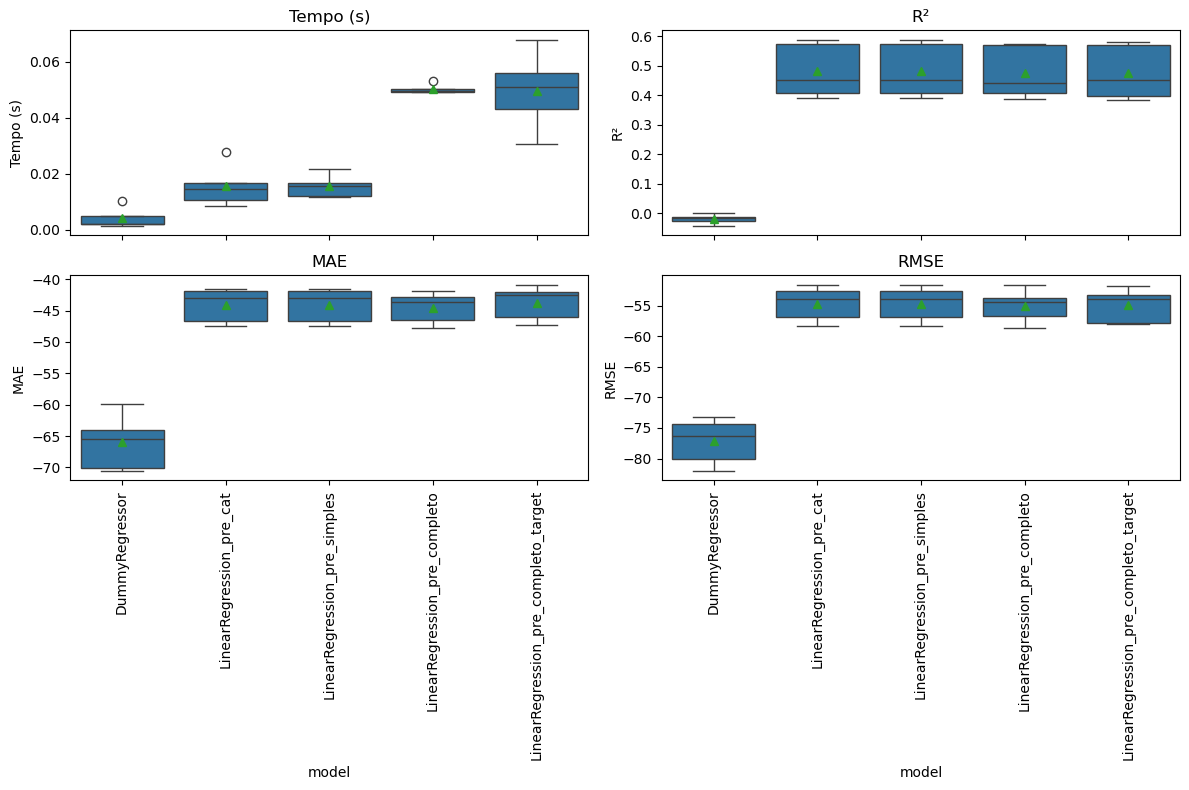

In [13]:
plot_comparar_metricas_modelos(df_resultados)